<a href="https://colab.research.google.com/github/Viroslav/CV_final_task/blob/main/Final_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Your task is to find the shaded segmentation mask.
Check out the guidelines_of_first_20_images folder. This folder is to illustrate and guide you for better understanding on the problem. 

You have to write an algorithm that will solve the following problem. Here are the instructions for your algorithm.

Inputs for the algorithm are in the dataset folder:
1. Image raw (the image folder)
2. Human parsing of the image 
3. Pose estimation of the person (both json and image) [*1]

Output:
1. The person's image with gray shaded region. Look at the sample_output.jpg for details.

Note: you don't have to use all the inputs given to you. You may use only those inputs that you find important for your algorithm to work better.



[*1]
body25 + hands labelling, check out the openpose labels for more details if you want.

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Final_task/Task'

## imports

In [3]:
import torch
import json
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from skimage.transform import rescale, ProjectiveTransform, warp
import pickle
import pandas as pd
import random
from skimage import io
from pylab import imshow

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from matplotlib import cm
from skimage.feature import canny
import imutils
from sklearn.metrics import accuracy_score

import warnings
import os
import torch
warnings.filterwarnings(action='ignore', category=DeprecationWarning)



np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


%matplotlib inline
from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Auxiliary Functions

In [4]:
def show(img, cmap=None):
    """
    function to plot image
    """
    
    plt.figure(figsize=(14,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

## work with data

In [5]:
%%time
human_parsing = {}
for img in os.listdir(path + '/dataset/human_parsing/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        human_parsing[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/human_parsing/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(human_parsing)} photos of human_parsing completed')

All 704 photos of human_parsing completed
CPU times: user 4.36 s, sys: 1.68 s, total: 6.04 s
Wall time: 18.4 s


In [6]:
%%time
image = {}
for img in os.listdir(path + '/dataset/image/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        image[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/image/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(image)} photos of image completed')

All 704 photos of image completed
CPU times: user 8.85 s, sys: 1.88 s, total: 10.7 s
Wall time: 23.5 s


In [7]:
%%time
pose_jpg = {}
for img in os.listdir(path + '/dataset/pose_img/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        pose_jpg[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/pose_img/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(pose_jpg)} photos of pose_jpg completed')

All 704 photos of pose_jpg completed
CPU times: user 8.02 s, sys: 2.8 s, total: 10.8 s
Wall time: 28.4 s


In [8]:
%%time
pose_json = {}
for key_p in os.listdir(path + '/dataset/pose_json/'):
    if key_p[-5:].lower() == '.json':
        # print(f' Loading: {key_p}')
        with open(f'{path}/dataset/pose_json/{key_p}', 'r') as f:
            pose_json[key_p]  = json.load(f)
print(f'All {len(pose_json)} of pose_json completed')

All 704 of pose_json completed
CPU times: user 251 ms, sys: 149 ms, total: 400 ms
Wall time: 10.9 s


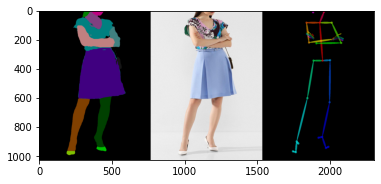

In [9]:
imshow(np.hstack([human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png']]))

## Thoughts

Use the points of the pelvis, complete the trapezoid to the ankles, subtract the mask of the hands from this

## Solution

In [10]:
pose_keypoints_2d = pose_json['168762_00_keypoints.json']['people'][0]['pose_keypoints_2d']

# To convert the list of keypoints into a more usable form, we can loop through the list in steps of 3
num_keypoints = int(len(pose_keypoints_2d) / 3)
keypoints = []
for i in range(num_keypoints):
    x = pose_keypoints_2d[i * 3]
    y = pose_keypoints_2d[i * 3 + 1]
    confidence = pose_keypoints_2d[i * 3 + 2]
    keypoints.append((x, y, confidence))

In [11]:
keypoints

[(422.798, 7.55812, 0.125119),
 (394.295, 79.8684, 0.851816),
 (303.66, 79.7733, 0.76211),
 (320.732, 215.98, 0.836236),
 (487.858, 193.199, 0.846076),
 (476.559, 79.9503, 0.799931),
 (541.739, 218.774, 0.782997),
 (371.733, 221.548, 0.501814),
 (414.184, 340.53, 0.553848),
 (351.829, 340.551, 0.55038),
 (309.427, 598.319, 0.728195),
 (235.8, 896.071, 0.759125),
 (465.346, 337.705, 0.517478),
 (462.247, 626.72, 0.774892),
 (411.386, 864.817, 0.773564),
 (0, 0, 0),
 (0, 0, 0),
 (349.047, 7.57927, 0.0774477),
 (0, 0, 0),
 (436.87, 941.286, 0.664097),
 (453.918, 932.792, 0.666011),
 (385.891, 870.418, 0.743521),
 (230.008, 969.691, 0.660155),
 (210.156, 963.988, 0.647822),
 (247.063, 910.171, 0.414717)]

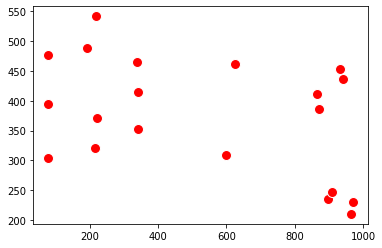

In [12]:
keypoints = pose_keypoints_2d
# reshape the data into (x, y) pairs
keypoints = [keypoints[i:i+3] for i in range(0, len(keypoints), 3)]
x = [point[0] for point in keypoints if point[2] > 0.4]
y = [point[1] for point in keypoints if point[2] > 0.4]

# plot the keypoints on a black background
fig, ax = plt.subplots()
fig.set_facecolor("white")
ax.scatter(y, x, c="red", s=100, edgecolors="white")
plt.axis("on")
plt.show()


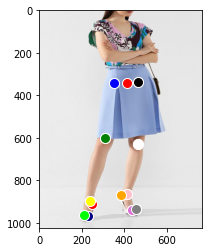

In [26]:
import matplotlib.image as mpimg

# read the image
img = image['168762_00.jpg']

# plot the image
fig, ax = plt.subplots()
ax.imshow(img)

# plot the keypoints on top of the image
keypoints = pose_keypoints_2d
keypoints = [keypoints[i:i+3] for i in range(0, len(keypoints), 3)]
x = [point[0] for point in keypoints if point[2] > 0.4]
y = [point[1] for point in keypoints if point[2] > 0.4]
ax.scatter(x[-13:], y[-13:], c="red", s=100, edgecolors="white")       #0
ax.scatter(x[-12:-11], y[-12:-11], c="blue", s=100, edgecolors="white")#1
ax.scatter(x[-11:-10], y[-11:-10], c="green", s=100, edgecolors="white")#2
ax.scatter(x[-10:-9], y[-10:-9], c="yellow", s=100, edgecolors="white")#3
ax.scatter(x[-9:-8], y[-9:-8], c="black", s=100, edgecolors="white")#4
ax.scatter(x[-8:-7], y[-8:-7], c="white", s=100, edgecolors="white")#5
ax.scatter(x[-7:-6], y[-7:-6], c="pink", s=100, edgecolors="white")#6
ax.scatter(x[-6:-5], y[-6:-5], c="orchid", s=100, edgecolors="white")#7
ax.scatter(x[-5:-4], y[-5:-4], c="gray", s=100, edgecolors="white")#8
ax.scatter(x[-4:-3], y[-4:-3], c="orange", s=100, edgecolors="white")#9
ax.scatter(x[-3:-2], y[-3:-2], c="navy", s=100, edgecolors="white")#10
ax.scatter(x[-2:-1], y[-2:-1], c="lime", s=100, edgecolors="white")#11

plt.axis("on")
plt.show()

In [30]:
pose_json_test = list(zip(x[-13:], y[-13:]))
pose_json_test

[(414.184, 340.53),
 (351.829, 340.551),
 (309.427, 598.319),
 (235.8, 896.071),
 (465.346, 337.705),
 (462.247, 626.72),
 (411.386, 864.817),
 (436.87, 941.286),
 (453.918, 932.792),
 (385.891, 870.418),
 (230.008, 969.691),
 (210.156, 963.988),
 (247.063, 910.171)]

## segment by points

In [58]:
def shaded_segmentation_mask(human_parsing, image, pose_jph, pose_json):

#-----------------------------------------------------------------------------#
    #Get the coordinates of the pelvis keypoints
    pelvis_left_point = pose_json[1]
    pelvis_right_point = pose_json[4]
    pelvis_left_x, pelvis_left_y = int(pelvis_left_point[0]), int(pelvis_left_point[1])
    pelvis_right_x, pelvis_right_y = int(pelvis_right_point[0]), int(pelvis_right_point[1])
#-----------------------------------------------------------------------------#
    # Get the coordinates of the right ankles keypoints
    #right 
    ankle_r_r_point = pose_json[6]
    ankle_r_r_x, ankle_r_r_y = int(ankle_r_r_point[0]), int(ankle_r_r_point[1])
    #left
    ankle_r_l_point = pose_json[9]
    ankle_r_l_x, ankle_r_l_y = int(ankle_r_l_point[0]), int(ankle_r_l_point[1])
#-----------------------------------------------------------------------------#
    # Get the coordinates of the left ankles keypoints
    #right 
    ankle_l_r_point = pose_json[12]
    ankle_l_r_x, ankle_l_r_y = int(ankle_l_r_point[0]), int(ankle_l_r_point[1])
    #left
    ankle_l_l_point = pose_json[3]
    ankle_l_l_x, ankle_l_l_y = int(ankle_l_l_point[0]), int(ankle_l_l_point[1])
#-----------------------------------------------------------------------------#    
    # Get the coordinates of the knees keypoints
    knee_l_point = pose_json[2]
    knee_r_point = pose_json[5]
    knee_l_x, knee_l_y = int(knee_l_point[0]), int(knee_l_point[1])
    knee_r_x, knee_r_y = int(knee_r_point[0]), int(knee_r_point[1])
#-----------------------------------------------------------------------------#
    # Create a mask representing the body of the person
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # adjust posture for knee position
    if knee_r_x > ankle_r_r_x:
        print('yes')


    else:
        print('no')
    
        
        cv2.fillConvexPoly(mask, np.array([[pelvis_right_x, pelvis_right_y], [knee_r_x, knee_r_y], 
                                       [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                                       [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], 
                                       [knee_l_x, knee_l_y], [pelvis_left_x, pelvis_left_y]]), 1)

    # Subtract the hands mask from the body mask
    hands_mask = np.logical_and(human_parsing == 17, human_parsing == 18)
    mask = np.logical_xor(mask, hands_mask[:, :, 1])

    # Combine the body mask with the human parsing mask
    final_mask = np.logical_or(mask, human_parsing[:, :, 1])

    return mask

yes


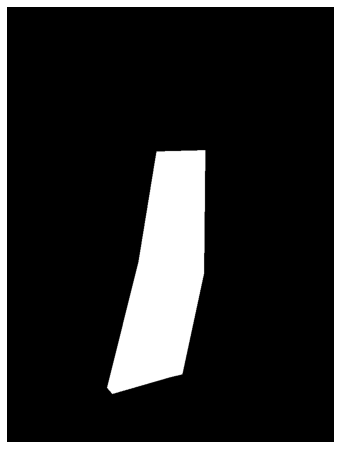

In [59]:
test = shaded_segmentation_mask(human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png'], pose_json_test)
show(test, cmap= 'gray')

## segment looping using cycles

In [17]:
pose_json_test

[(414.184, 340.53),
 (351.829, 340.551),
 (309.427, 598.319),
 (235.8, 896.071),
 (465.346, 337.705),
 (462.247, 626.72),
 (411.386, 864.817),
 (436.87, 941.286),
 (453.918, 932.792),
 (385.891, 870.418),
 (230.008, 969.691),
 (210.156, 963.988),
 (247.063, 910.171)]

In [18]:
human_parsing_test = cv2.cvtColor(human_parsing['168762_00.png'], cv2.COLOR_RGB2GRAY)

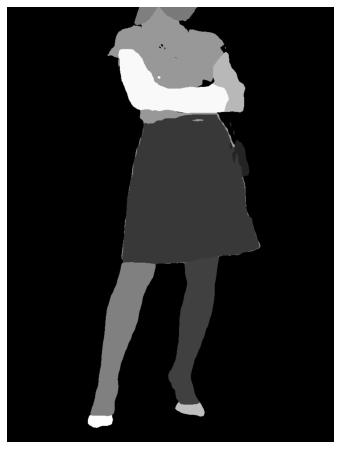

In [19]:
show(human_parsing_test, cmap='gray')

In [20]:
np.unique(human_parsing_test)

array([  0,  22,  34,  38,  72,  75,  76,  90, 109, 113, 147, 151],
      dtype=uint8)

g


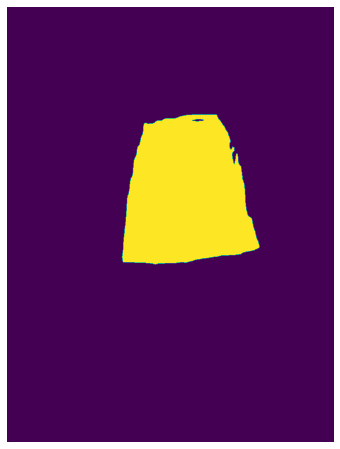

87586
g


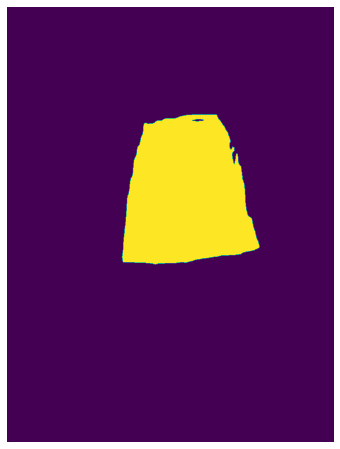

87586
g


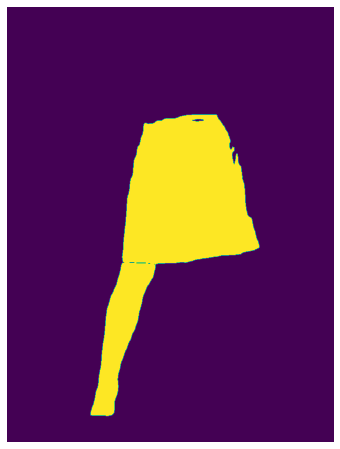

110381
g


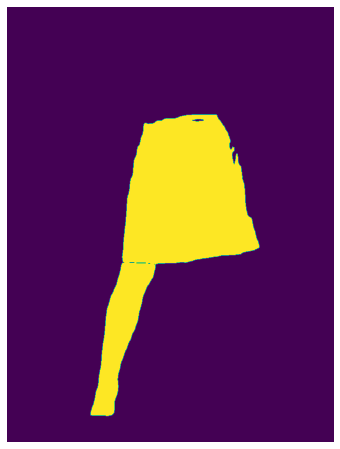

110381
g


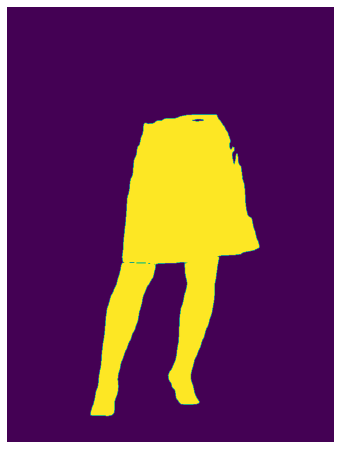

131274
g


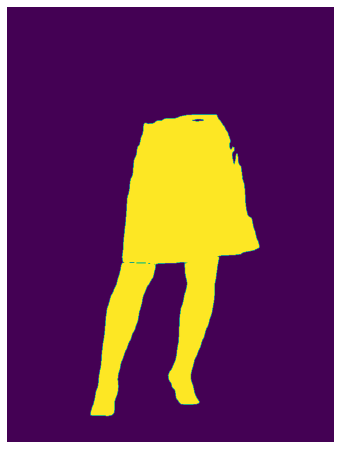

131274


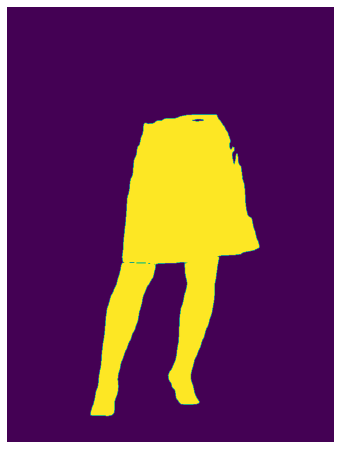

In [21]:
def shaded_segmentation_mask(image, human_parsing, pose_json):
    # Create a black mask with the same size as the image
    mask = np.zeros_like(image[:, :, 0])

    # Iterate over the key points
    for x, y in pose_json:
        # Check if the point falls into the body part or clothes region in the human parsing mask
        if human_parsing[int(y), int(x)] in np.unique(human_parsing):
            print('g')
            # If the point falls into a body part or clothes region, include it in the mask
            mask[human_parsing == human_parsing[int(y), int(x)]] = 1
            #mask[int(y), int(x)] = 100
            show(mask)
            #print(mask.sum())
            
    # Apply morphological operations to fill in the gaps in the mask
    #kernel = np.ones((5, 5), np.uint8)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Apply the mask to the image
    #result = cv2.bitwise_and(image, mask)

    return mask
test_show = shaded_segmentation_mask(image['168762_00.jpg'], human_parsing_test, pose_json_test[1:7])
show(test_show)

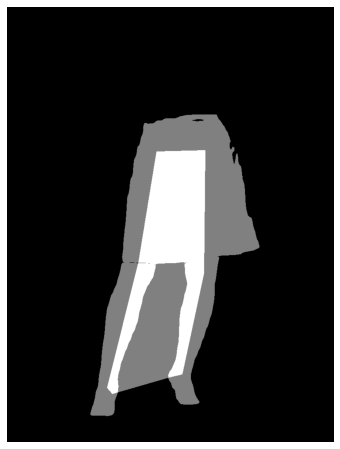

In [47]:
total = test + test_show
show(total, cmap = 'gray')

In [48]:
np.unique(total)

array([0, 1, 2], dtype=uint8)

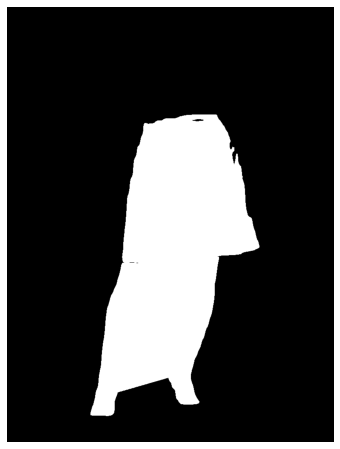

In [49]:
gray_indices = np.where(total == 2)

# set the values of the gray pixels to 1 (white)
total[gray_indices] = 1
show(total, cmap='gray')

## plot all together

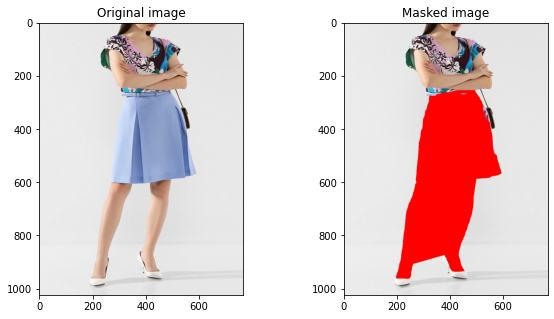

In [53]:

masked_image = np.copy(image['168762_00.jpg'])
masked_image[:,:,0][total == 1] = 255
masked_image[:,:,1][total == 1] = 0
masked_image[:,:,2][total == 1] = 0

# plot the original image and the masked image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image['168762_00.jpg'])
ax[0].set_title('Original image')
ax[1].imshow(masked_image)
ax[1].set_title('Masked image')
plt.show()


In [50]:
imshow(np.hstack([human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png'], total]))

ValueError: ignored

## shit

In [ ]:
np.unique(human_parsing['168762_00.png'])

array([  0,  22,  64, 128, 192], dtype=uint8)

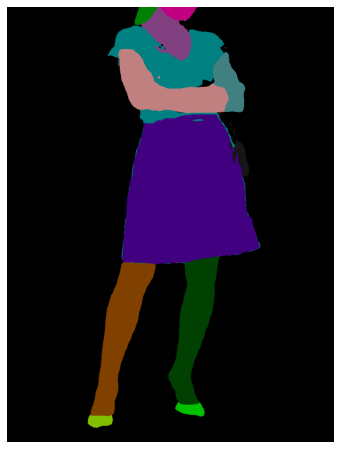

In [ ]:
show(human_parsing['168762_00.png'])

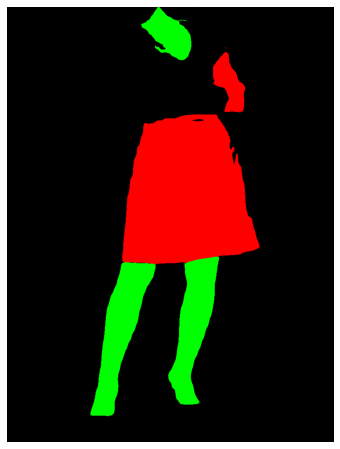

In [ ]:
binary_mask = np.zeros_like(human_parsing['168762_00.png'], dtype=np.uint8)
binary_mask[human_parsing['168762_00.png'] == 64] = 255
show(binary_mask)

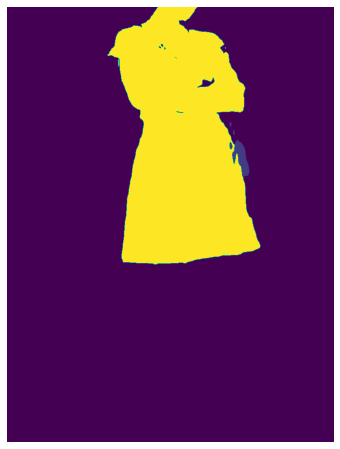

In [ ]:
show(human_parsing['168762_00.png'][:, :, 2])

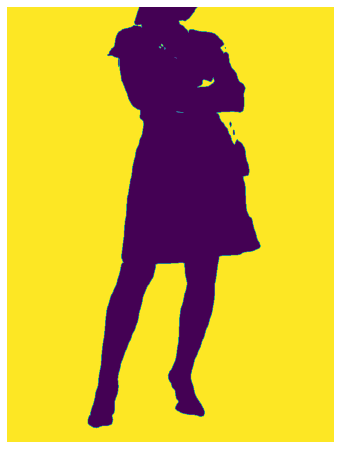

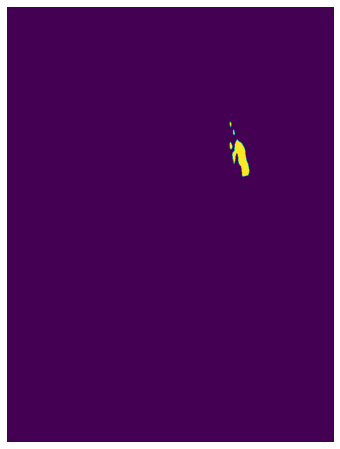

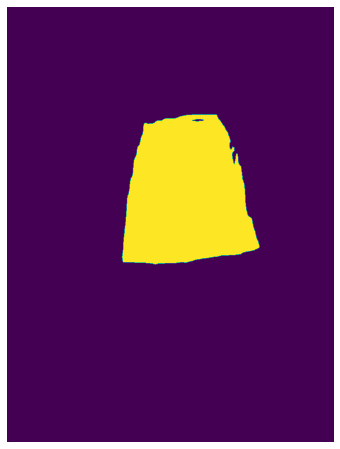

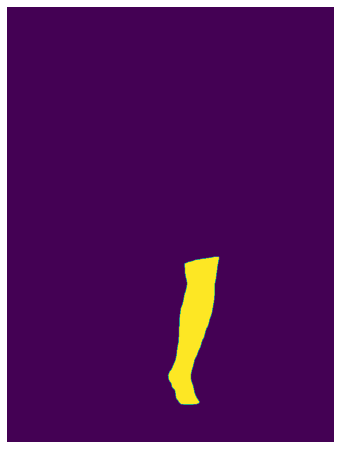

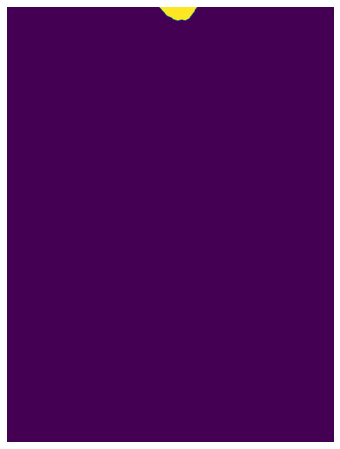

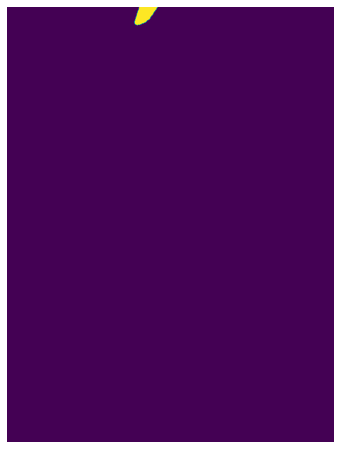

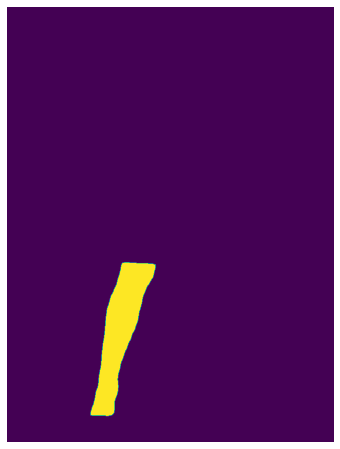

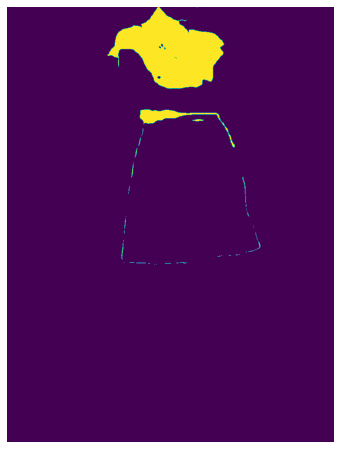

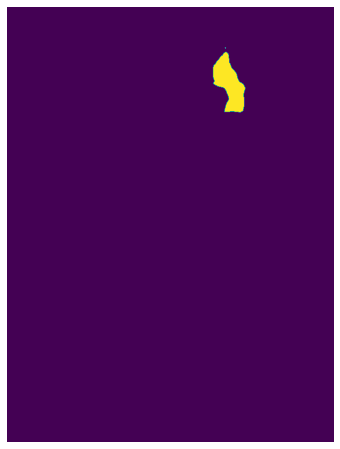

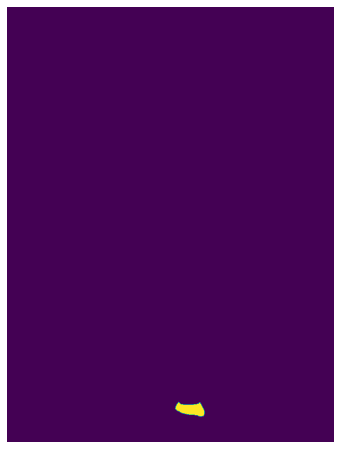

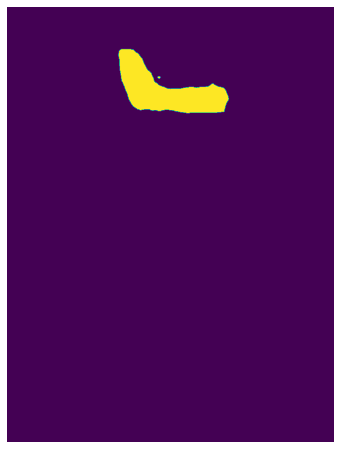

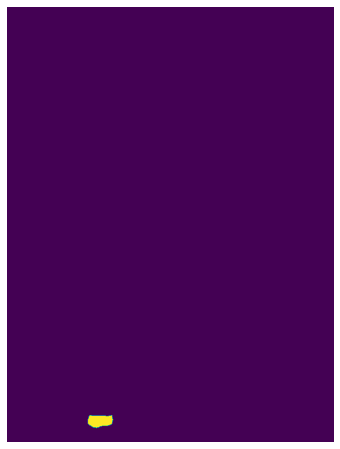

In [ ]:
def binary_mask(human_parsing):
    unique_values = np.unique(human_parsing)
    for value in unique_values:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        show(binary_mask)
        
binary_mask(human_parsing_test)

In [ ]:
binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
binary_mask[human_parsing == value] = 255
show(binary_mask)

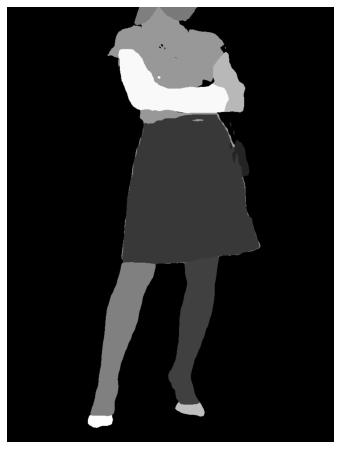

In [ ]:
show(human_parsing_test, cmap = 'gray')

In [ ]:
binary_mask(human_parsing_test, pose_json_test)

In [ ]:
np.unique(human_parsing_test)

array([  0,  22,  34,  38,  72,  75,  76,  90, 109, 113, 147, 151],
      dtype=uint8)

0
22
34


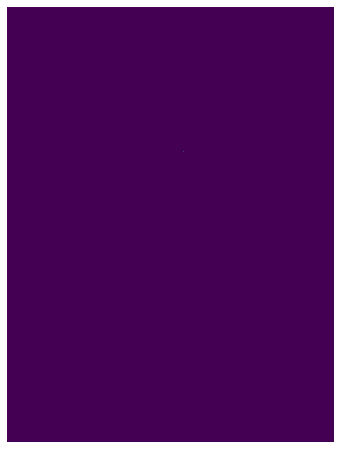

38
72
75
76
90
109
113
147
151
0
22
34


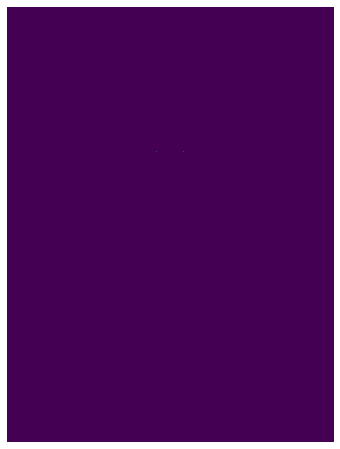

38
72
75
76
90
109
113
147
151
0
22
34


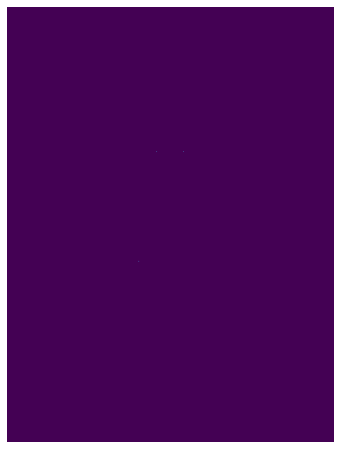

38
72
75
76
90
109
113
147
151
0
22
34
38
72
75
76


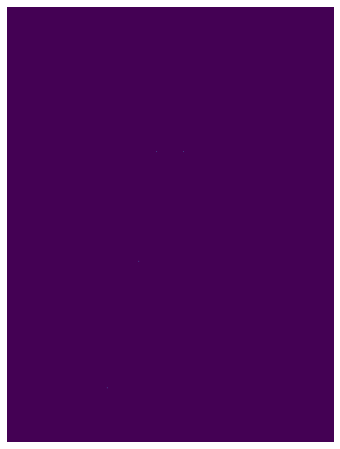

90
109
113
147
151
0
22
34


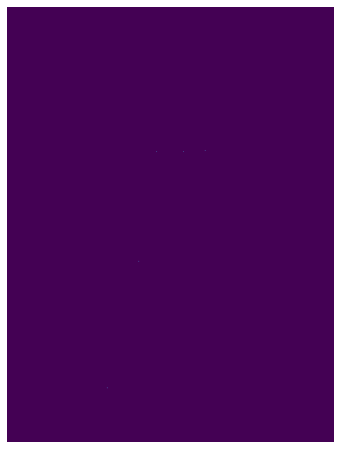

38
72
75
76
90
109
113
147
151
0
22
34
38


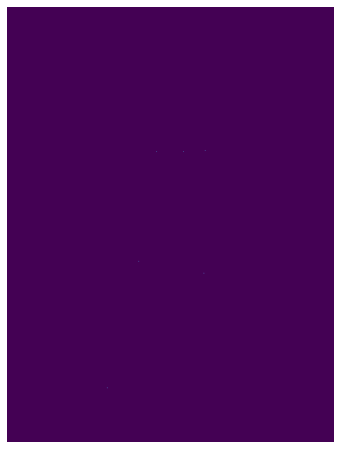

72
75
76
90
109
113
147
151
0
22
34
38


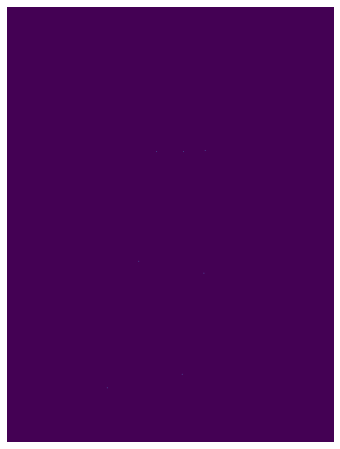

72
75
76
90
109
113
147
151
0
22
34
38
72
75
76
90
109
113


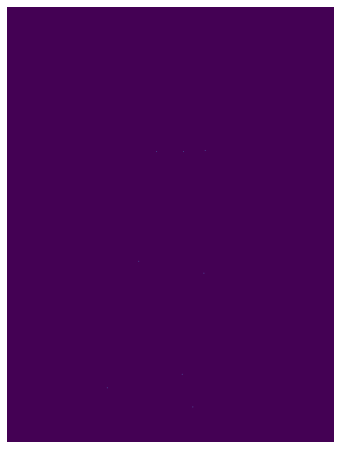

147
151
0
22
34
38
72
75
76
90
109
113


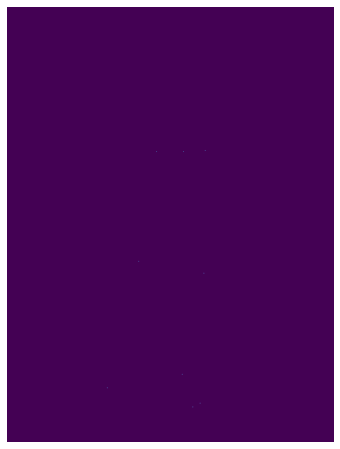

147
151
0
22
34
38


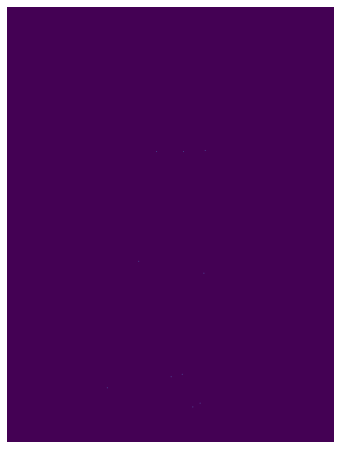

72
75
76
90
109
113
147
151
0
22
34
38
72
75
76
90
109
113
147
151


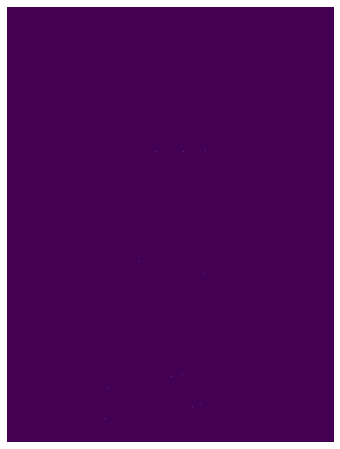

0
22
34
38
72
75
76
90
109
113
147
151


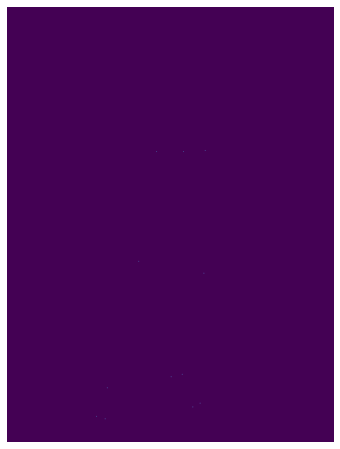

0
22
34
38
72
75
76


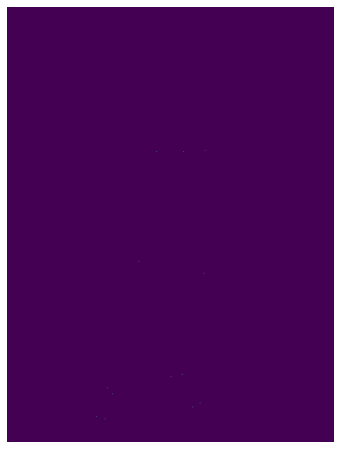

90
109
113
147
151


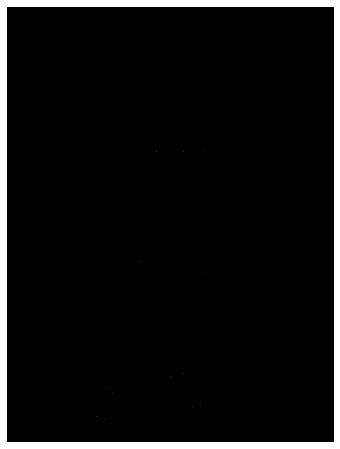

In [ ]:
def shaded_segmentation_mask(human_parsing, pose_json_test):
    mask = np.zeros(human_parsing.shape, dtype=np.uint8)
    for x, y in pose_json_test:
        x, y = int(x), int(y)
        unique_values = np.unique(human_parsing)
        for value in unique_values:
            print(value)
            if human_parsing[y, x] == value:
                mask[y, x] = 255
                show(mask)
    return mask

mask = shaded_segmentation_mask(human_parsing_test, pose_json_test)
show(mask, cmap = 'gray')

In [ ]:
human_parsing['168762_00.png'].shape[1]

768

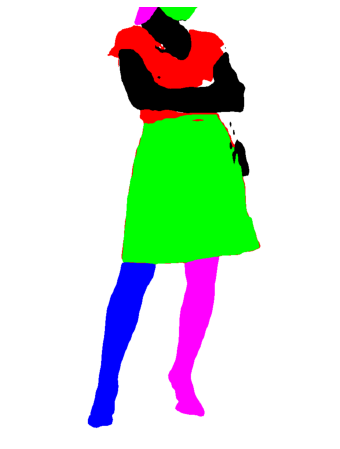

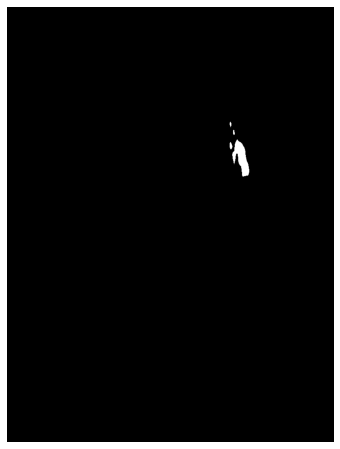

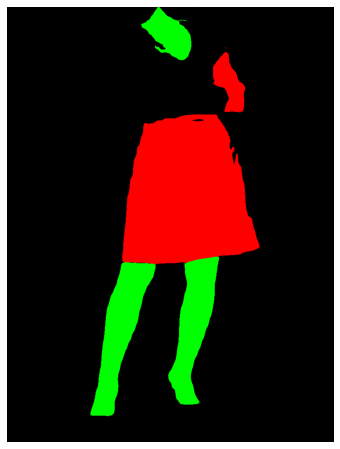

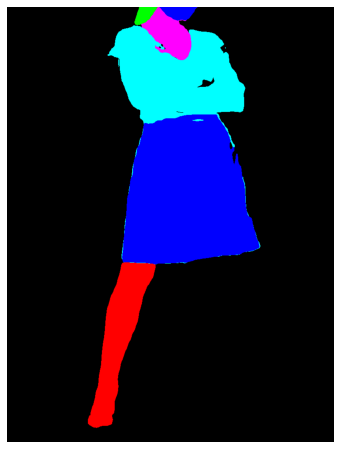

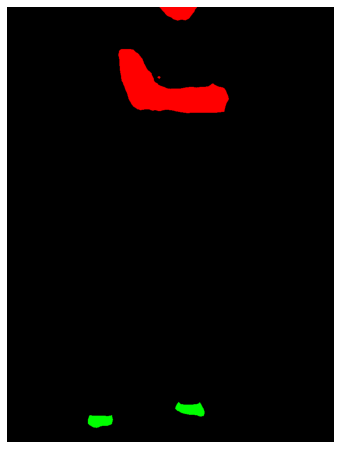

In [ ]:
def binary_mask(human_parsing, key_points):
    unique_values = np.unique(human_parsing)
    for value in unique_values:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        show(binary_mask)
        
binary_mask(human_parsing['168762_00.png'], pose_json_test)

In [ ]:
def shaded_segmentation_mask(human_parsing, key_points):
    # Initialize a binary mask with the same shape as the human parsing image
    mask = np.zeros_like(human_parsing, dtype=np.uint8)
    
    # Get unique values in the human parsing image
    unique_values = np.unique(human_parsing)
    
    # Iterate over each unique value
    for value in unique_values:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        
        # Create a convex hull of the key points that fall into the binary mask
        key_points_in_mask = [point for point in key_points if binary_mask[int(point[1]), int(point[0])] == 255]
        if len(key_points_in_mask) > 0:
            hull = cv2.convexHull(np.array(key_points_in_mask, dtype=np.int32))
            cv2.fillPoly(mask, [hull], value)
    
    return mask
shaded_segmentation_mask(human_parsing['168762_00.png'], pose_json_test)

ValueError: ignored

In [ ]:
human_parsing['168762_00.png'].shape

(1024, 768, 3)

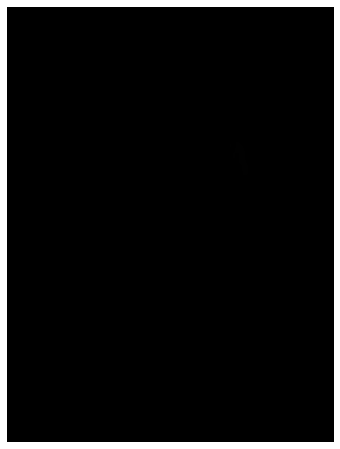

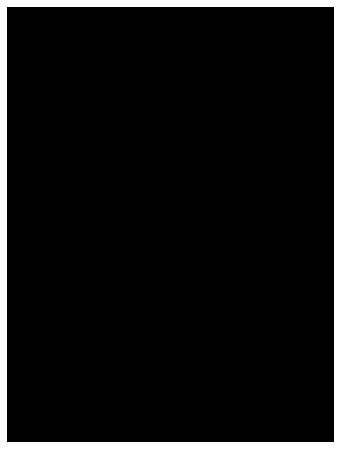

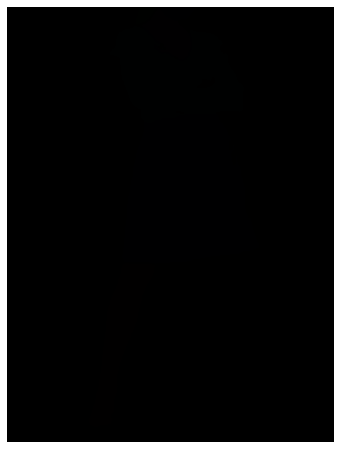

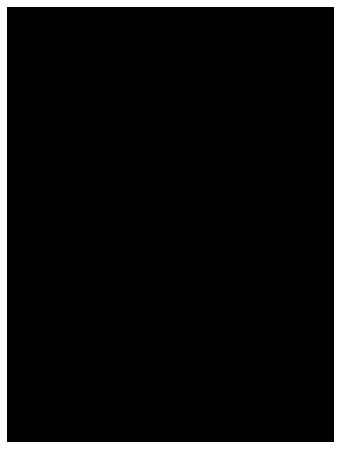

In [ ]:
def shaded_segmentation_mask(human_parsing, pose_json_test):
    mask = np.zeros_like(human_parsing)
    body_parts = [22, 64, 128, 192]
    for part in body_parts:
        part_mask = np.where(human_parsing == part, 1, 0)
        show(part_mask, cmap = None)
shaded_segmentation_mask(human_parsing['168762_00.png'], pose_json_test)

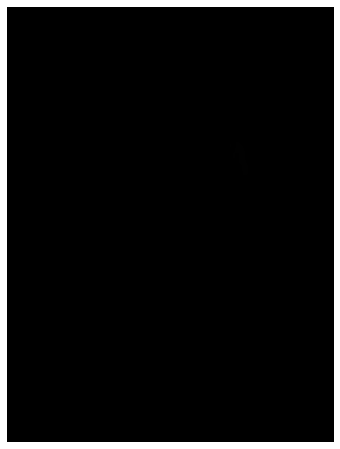

ValueError: ignored

In [ ]:
def shaded_segmentation_mask(human_parsing, pose_json_test):
    mask = np.zeros_like(human_parsing)
    body_parts = [22, 64, 128, 192]
    for part in body_parts:
        part_mask = np.where(human_parsing == part, 1, 0)
        show(part_mask)
        for (x, y) in pose_json_test:
            if x >= 0 and x < human_parsing.shape[1] and y >= 0 and y < human_parsing.shape[0]:
                if part_mask[int(y), int(x)] == 1:
                    mask[np.where(human_parsing == part)] = 1
                    break
    return mask

mask = shaded_segmentation_mask(human_parsing['168762_00.png'], pose_json_test)

In [ ]:
show(np.logical_and(human_parsing['168762_00.png'] == 22, human_parsing['168762_00.png'] == 64))

ValueError: ignored

<Figure size 1008x576 with 1 Axes>

In [ ]:
test = shaded_segmentation_mask(image['168762_00.jpg'], human_parsing['168762_00.png'], pose_json_test)
show(test, cmap= 'gray')

ValueError: ignored

In [ ]:
pose_json_test = list(zip(x[-13:], y[-13:]))

In [ ]:
pose_json_test

[(414.184, 340.53),
 (351.829, 340.551),
 (309.427, 598.319),
 (235.8, 896.071),
 (465.346, 337.705),
 (462.247, 626.72),
 (411.386, 864.817),
 (436.87, 941.286),
 (453.918, 932.792),
 (385.891, 870.418),
 (230.008, 969.691),
 (210.156, 963.988),
 (247.063, 910.171)]

In [ ]:
points = np.array([[int(x), int(y)] for x, y in pose_json_test[5:]], np.int32)
points

array([[462, 626],
       [411, 864],
       [436, 941],
       [453, 932],
       [385, 870],
       [230, 969],
       [210, 963],
       [247, 910]], dtype=int32)

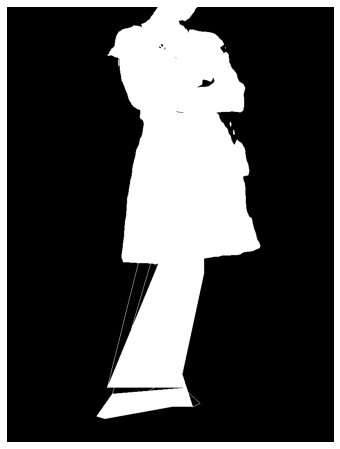

In [ ]:
points = np.array([[int(x), int(y)] for x, y in pose_json_test[:]], np.int32)
def shaded_segmentation_mask(human_parsing, image, pose_jph, pose_json):

    # Create a mask representing the body of the person
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, points, 1)

    # Combine the body mask with the human parsing mask
    final_mask = np.logical_or(mask, human_parsing[:, :, 2])

    return final_mask

                                    
test = shaded_segmentation_mask(human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png'], test_dic)
show(test, cmap='gray')

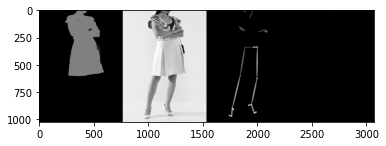

In [ ]:
imshow(np.hstack([human_parsing['168762_00.png'][:,:,2], image['168762_00.jpg'][:,:,2], pose_jpg['168762_00_rendered.png'][:,:,2], test]), cmap = 'gray')